# Image to Embedding

Use ResNet50 as a feature extractor by removing the final layer and feeding its embeddings into a new classifier.

In [1]:
# Import dependencies
import torch
from torchvision import models, transforms
import torch.nn.functional as F
from PIL import Image

# Image Preprocessing

In [2]:
# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# The numbers mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] are specific
# because they represent the channel-wise mean and standard deviation of pixel values
# for the images in the ImageNet dataset, on which models like ResNet are pre-trained.

# Load and preprocess the image
def preprocess_image(path):
    img = Image.open(path)
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

In [3]:
corgi_tensor = preprocess_image("data/corgi1.jpg")
print(corgi_tensor.shape)
print(corgi_tensor)

torch.Size([1, 3, 224, 224])
tensor([[[[-1.3302, -1.3815, -1.3987,  ..., -1.0390, -1.0219, -0.9363],
          [-1.3987, -1.4329, -1.4329,  ..., -0.9877, -1.0390, -1.0048],
          [-1.4158, -1.4672, -1.4672,  ..., -1.0219, -1.0904, -1.0904],
          ...,
          [-0.7137, -0.6452, -0.6109,  ..., -0.4054, -0.3369, -0.2684],
          [-0.8335, -0.6623, -0.6281,  ..., -0.3712, -0.2856, -0.2171],
          [-0.9534, -0.7137, -0.5767,  ..., -0.3198, -0.2171, -0.1999]],

         [[-0.6352, -0.6352, -0.6176,  ..., -0.4426, -0.4601, -0.3725],
          [-0.7052, -0.7227, -0.6877,  ..., -0.4251, -0.4601, -0.4251],
          [-0.7402, -0.7577, -0.7752,  ..., -0.4426, -0.5301, -0.4951],
          ...,
          [-0.3550, -0.1800, -0.1625,  ..., -0.3725, -0.3200, -0.2500],
          [-0.4251, -0.2850, -0.2850,  ..., -0.3725, -0.3025, -0.2850],
          [-0.5826, -0.4426, -0.3725,  ..., -0.3550, -0.2850, -0.3025]],

         [[-0.5321, -0.5321, -0.5321,  ..., -0.6890, -0.7238, -0.6367],
 

# Prepare Model

In [4]:
# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

/Users/dima/Projects/ai/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dima/Projects/ai/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Remove the final fully connected layer to get embeddings
modules = list(model.children())[:-1]
model = torch.nn.Sequential(*modules)

In [6]:
# Set the model to evaluation mode (aka "inference" mode)
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


# Extract the Embedding Vector

In [7]:
with torch.no_grad():
    corgi1_embedding = model(corgi_tensor)
    corgi1_embedding = corgi1_embedding.view(corgi1_embedding.size(0), -1)  # Flatten the output

In [8]:
print(corgi1_embedding.shape)
print(corgi1_embedding[0])

torch.Size([1, 2048])
tensor([0.6412, 0.4579, 0.4030,  ..., 0.1361, 0.8415, 0.2980])


In [9]:
with torch.no_grad():
    corgi2_embedding = model(preprocess_image("data/corgi2.jpg"))
    corgi2_embedding = corgi2_embedding.view(corgi2_embedding.size(0), -1)
    corgi3_embedding = model(preprocess_image("data/corgi3.jpg"))
    corgi3_embedding = corgi3_embedding.view(corgi3_embedding.size(0), -1)
    corgi4_embedding = model(preprocess_image("data/corgi4.jpg"))
    corgi4_embedding = corgi4_embedding.view(corgi4_embedding.size(0), -1)
    cat1_embedding = model(preprocess_image("data/cat1.jpg"))
    cat1_embedding = cat1_embedding.view(cat1_embedding.size(0), -1)

In [10]:
print("Corgi 1 vs. Corgi 2: %s " % F.cosine_similarity(corgi1_embedding[0].unsqueeze(0), corgi2_embedding[0].unsqueeze(0)))
print("Corgi 1 vs. Corgi 3: %s " % F.cosine_similarity(corgi1_embedding[0].unsqueeze(0), corgi3_embedding[0].unsqueeze(0)))
print("Corgi 1 vs. Corgi 4: %s " % F.cosine_similarity(corgi1_embedding[0].unsqueeze(0), corgi4_embedding[0].unsqueeze(0)))
print("Corgi 1 vs. Cat 1: %s " % F.cosine_similarity(corgi1_embedding[0].unsqueeze(0), cat1_embedding[0].unsqueeze(0)))

Corgi 1 vs. Corgi 2: tensor([0.8828]) 
Corgi 1 vs. Corgi 3: tensor([0.8577]) 
Corgi 1 vs. Corgi 4: tensor([0.8582]) 
Corgi 1 vs. Cat 1: tensor([0.5927]) 


Great result!

In [11]:
from IPython.display import Image as IPImage, display

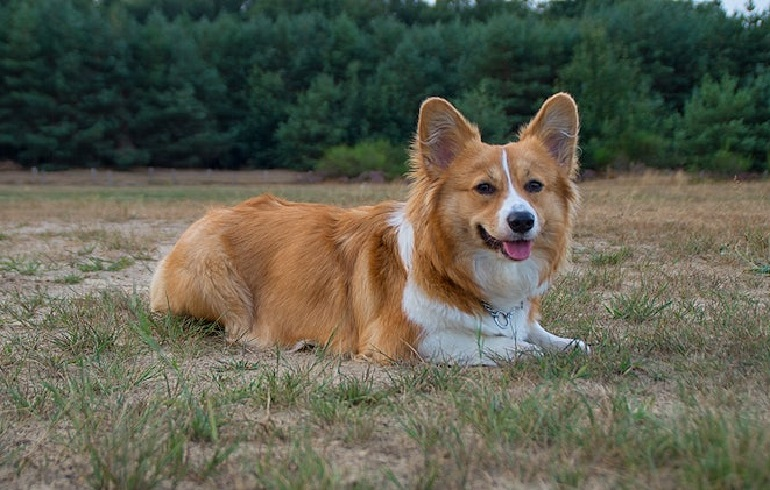

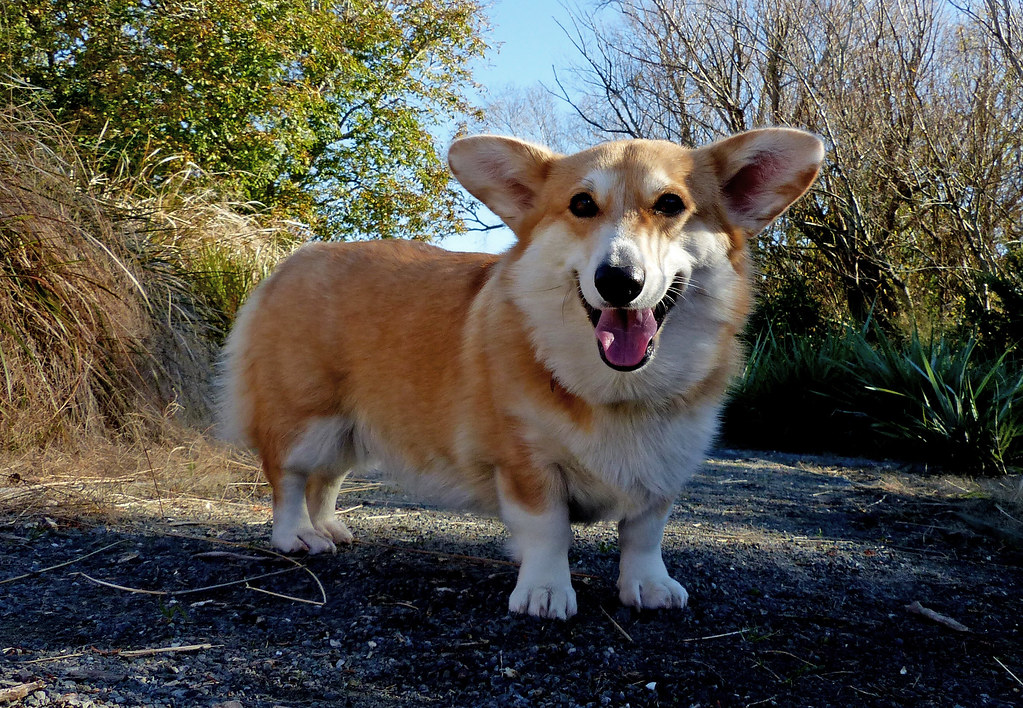

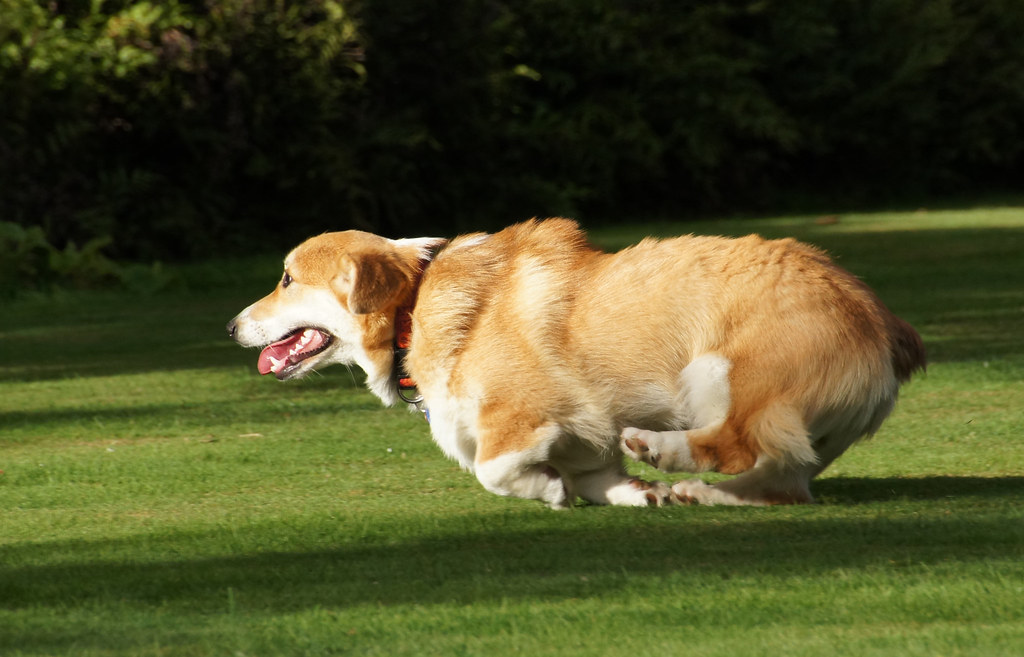

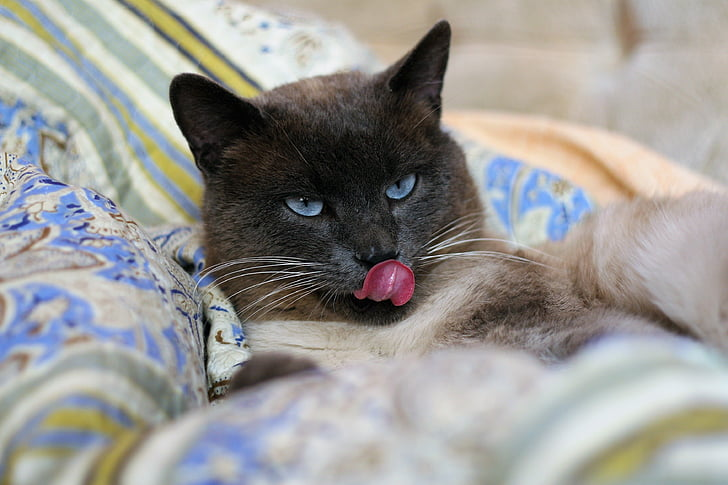

In [12]:
display(IPImage('data/corgi1.jpg'))
display(IPImage('data/corgi2.jpg'))
display(IPImage('data/corgi3.jpg'))
display(IPImage('data/cat1.jpg'))